In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna, warnings, random
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl


In [7]:
df = pd.read_csv('AIDS_Classification.csv', delimiter = ',', encoding ='UTF-8')
df.head()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,...,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,3,0,0,0,504,353,870,782,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      2139 non-null   int64  
 1   trt       2139 non-null   int64  
 2   age       2139 non-null   int64  
 3   wtkg      2139 non-null   float64
 4   hemo      2139 non-null   int64  
 5   homo      2139 non-null   int64  
 6   drugs     2139 non-null   int64  
 7   karnof    2139 non-null   int64  
 8   oprior    2139 non-null   int64  
 9   z30       2139 non-null   int64  
 10  preanti   2139 non-null   int64  
 11  race      2139 non-null   int64  
 12  gender    2139 non-null   int64  
 13  str2      2139 non-null   int64  
 14  strat     2139 non-null   int64  
 15  symptom   2139 non-null   int64  
 16  treat     2139 non-null   int64  
 17  offtrt    2139 non-null   int64  
 18  cd40      2139 non-null   int64  
 19  cd420     2139 non-null   int64  
 20  cd80      2139 non-null   int6

In [11]:
# Checking null values
df.isnull().sum()

time        0
trt         0
age         0
wtkg        0
hemo        0
homo        0
drugs       0
karnof      0
oprior      0
z30         0
preanti     0
race        0
gender      0
str2        0
strat       0
symptom     0
treat       0
offtrt      0
cd40        0
cd420       0
cd80        0
cd820       0
infected    0
dtype: int64

In [12]:
# Checking duplicate values
print(df.duplicated().sum())

0


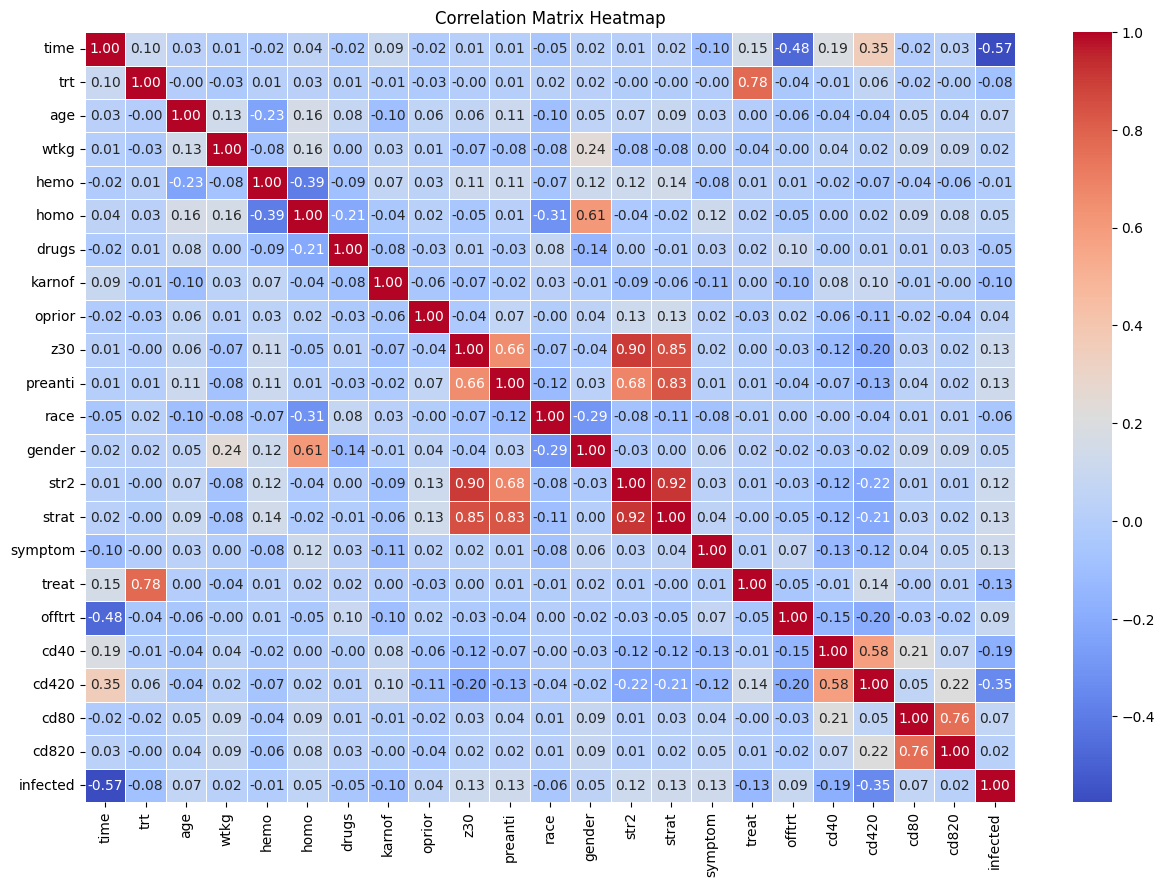

In [13]:
# Compute the correlation matrix
correlation_matrix = df.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

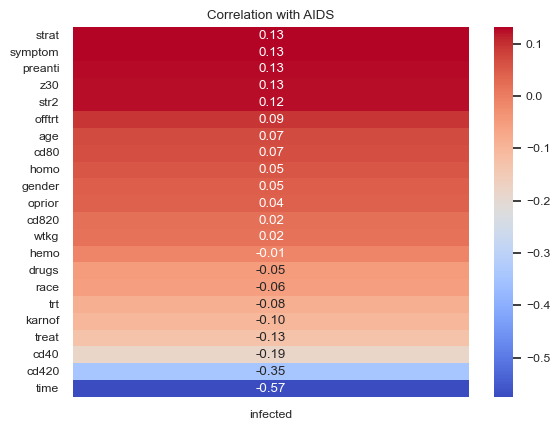

In [15]:
#Graph II
# Create a heatmap of the correlations with the target column
corr = df.corr()
target_corr = corr['infected'].drop('infected')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with AIDS')
plt.show()

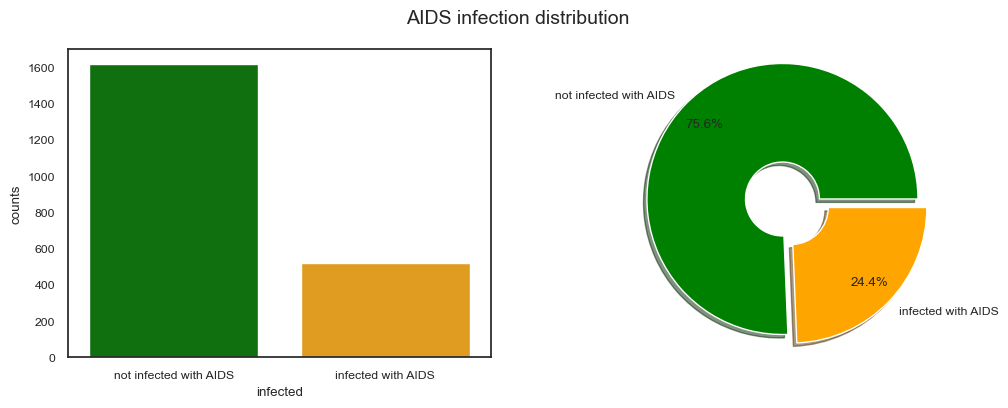

In [16]:
grouped_infect = df.groupby("infected")["infected"].count().reset_index(name="counts")
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(x=grouped_infect.infected, y=grouped_infect.counts, palette=["green", "orange"])
plt.xticks(ticks=(0,1), labels=["not infected with AIDS", "infected with AIDS"])
plt.subplot(1,2,2)
plt.pie(x=grouped_infect.counts, shadow=True, autopct="%.1f%%", pctdistance=0.8,
        labels=["not infected with AIDS", "infected with AIDS"], colors=["green", "orange"],
        radius=1.4-0.3, wedgeprops=dict(width=0.8), explode= [0.05,0.05])
plt.suptitle("AIDS infection distribution", fontsize=14)
plt.show()

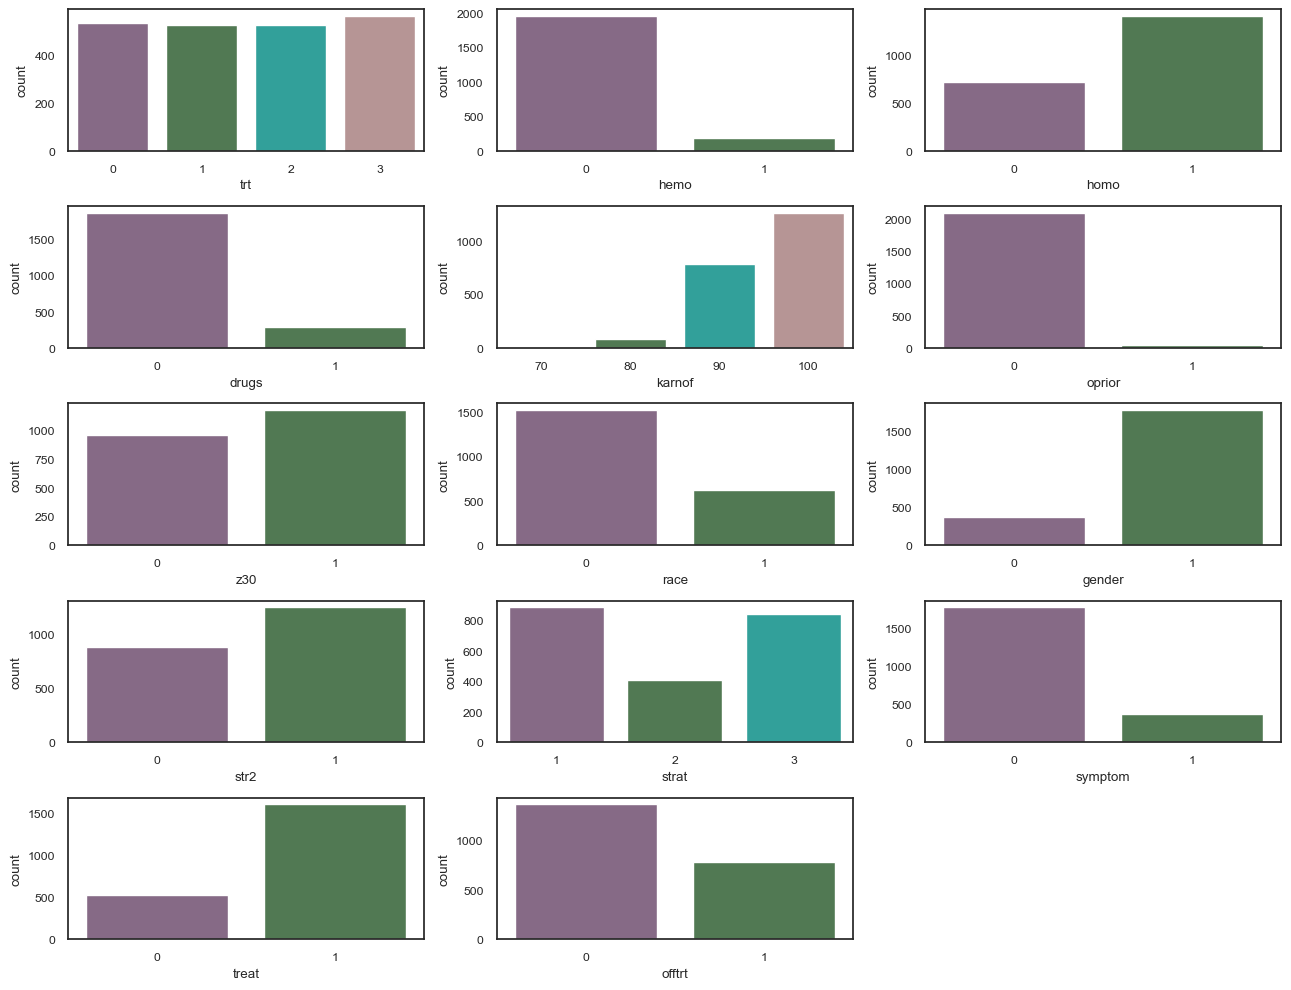

In [17]:
cat_cols = ["trt", "hemo", "homo", "drugs", "karnof", "oprior", "z30",
            "race", "gender", "str2", "strat", "symptom", "treat", "offtrt"]
clr = ["#8b658b", "#4a804d", "#20b2aa", "#bc8f8f", "#6495ed"]
plt.figure(figsize=(13,10))

for i, col in enumerate(cat_cols):
    plt.subplot(5,3, i+1)
    sns.barplot(x=df[col].value_counts().index, y=df[col].value_counts(), palette=clr)
plt.tight_layout()
plt.show()

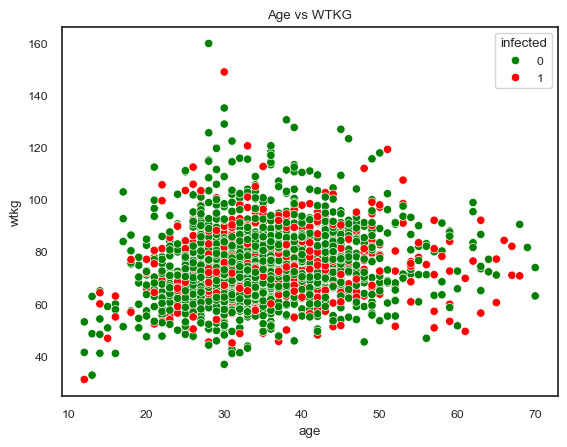

In [18]:
# Scatterplot Age vs BMI colored by Diabetes classification
sns.scatterplot(x='age', y='wtkg', hue='infected',palette=["green", "red"], data=df)
plt.title('Age vs WTKG')
plt.show()

In [19]:
# Identify features and target variable
X = df.drop('infected', axis=1)
y = df['infected']

In [20]:
from imblearn.over_sampling import RandomOverSampler

# Apply oversampling using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

In [21]:
# Combine oversampled features and target back into a DataFrame
oversampled_df = pd.DataFrame(X_oversampled, columns=X.columns)
oversampled_df['infected'] = y_oversampled

from sklearn import preprocessing
pre_process = preprocessing.MinMaxScaler().fit(X_oversampled)
x_transform = pre_process.fit_transform(X_oversampled)


# Use x and y variables to split the training data into train and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_transform, y_oversampled, test_size = .10, random_state = 101)

BEFORE BALANCING


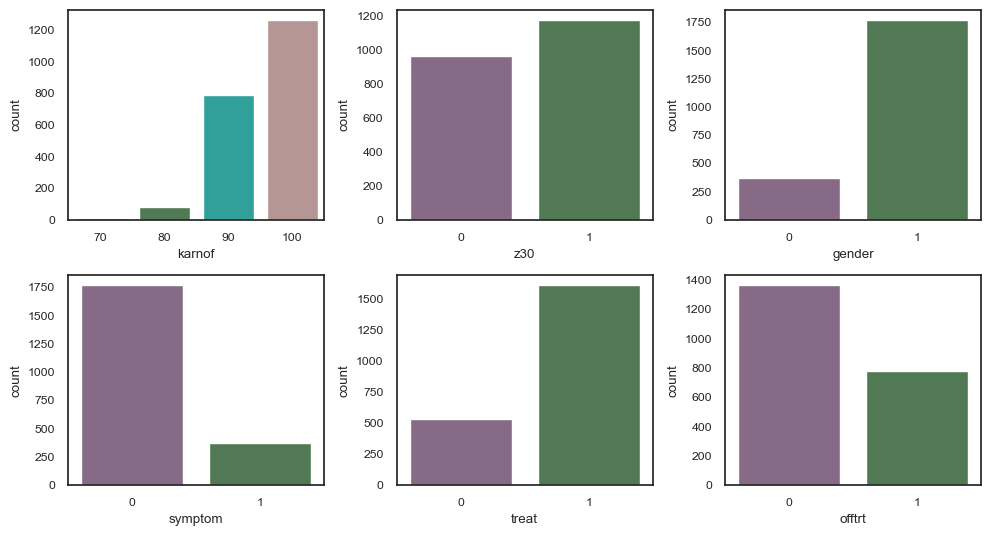

AFTER BALANCING


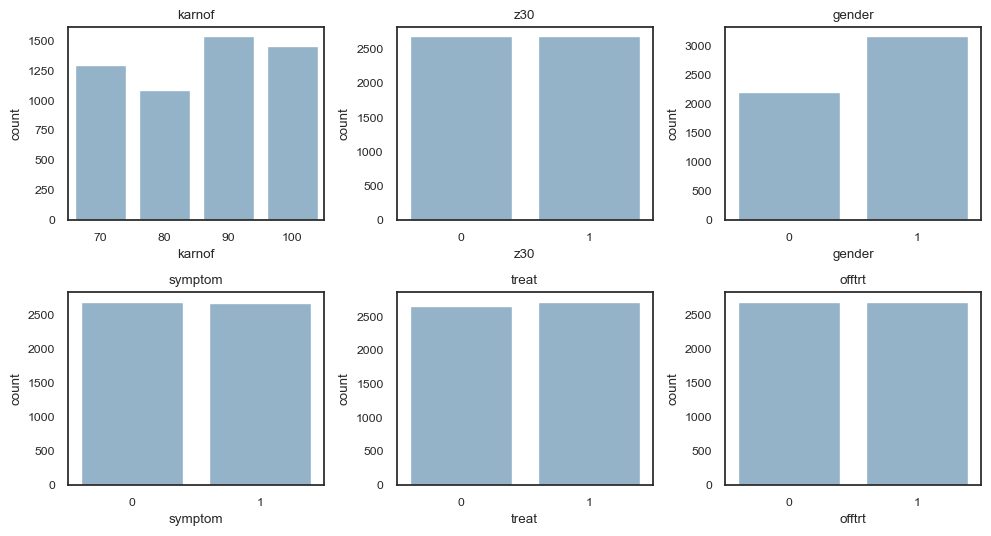

In [22]:
#Some examples of the data distributions

#=========================================BEFORE========================================================================#
print("BEFORE BALANCING")
cat_colsxmp = ["karnof", "z30", "gender", "symptom", "treat", "offtrt"]
clr = ["#8b658b", "#4a804d", "#20b2aa", "#bc8f8f", "#6495ed"]
plt.figure(figsize=(10,13))

for i, col in enumerate(cat_colsxmp):
    plt.subplot(5,3, i+1)
    sns.barplot(x=df[col].value_counts().index, y=df[col].value_counts(), palette=clr)
plt.tight_layout()
plt.show()

#=========================================AFTER========================================================================#
print("AFTER BALANCING")
# Identify features and target variable
X = df.drop('infected', axis=1)
y = df['infected']

# Apply oversampling using RandomOverSampler to the target variable first
oversampler = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

# Combine oversampled features and target back into a DataFrame
oversampled_df = pd.DataFrame(X_oversampled, columns=X.columns)
oversampled_df['infected'] = y_oversampled

# Get the maximum count for any category in any feature
cat_cols = ["karnof", "z30", "gender", "symptom", "treat", "offtrt"]
max_count = 0
for col in cat_cols:
    max_count = max(max_count, oversampled_df[col].value_counts().max())

# Function to balance each categorical feature to the max_count
def balance_to_max_count(df, feature, max_count):
    balanced_df_list = []
    for value in df[feature].unique():
        subset = df[df[feature] == value]
        if len(subset) < max_count:
            samples_needed = max_count - len(subset)
            # Duplicate the existing samples to meet the required count
            additional_samples = subset.sample(samples_needed, replace=True, random_state=42)
            balanced_df_list.append(pd.concat([subset, additional_samples], axis=0))
        else:
            balanced_df_list.append(subset.sample(max_count, replace=True, random_state=42))
    return pd.concat(balanced_df_list, axis=0)

# Balance each categorical feature to the max_count
for col in cat_cols:
    oversampled_df = balance_to_max_count(oversampled_df, col, max_count)

# Plot the balanced data for each categorical feature
plt.figure(figsize=(10, 13))
for i, col in enumerate(cat_cols):
    plt.subplot(5, 3, i + 1)
    sns.countplot(x=oversampled_df[col])
    plt.title(col)
    plt.tight_layout()
plt.show()

Logistic Regression
Logistic Regression
------------------------------------------------------------
Accuracy 83.02 %
Precision: 0.87
Recall: 0.79
------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       158
           1       0.87      0.79      0.83       166

    accuracy                           0.83       324
   macro avg       0.83      0.83      0.83       324
weighted avg       0.83      0.83      0.83       324



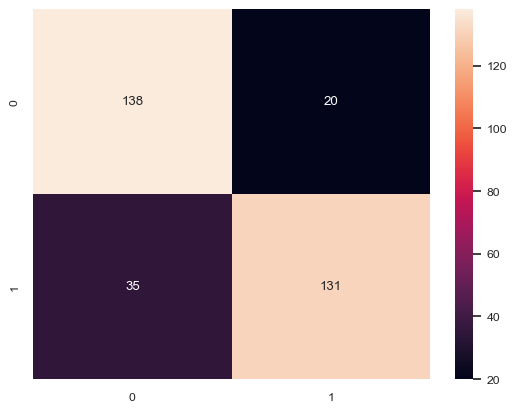

In [23]:
# Import model
from sklearn.linear_model import LogisticRegression

print('Logistic Regression')
# Create instance of model
log_reg = LogisticRegression()

# Pass training data into model
log_reg.fit(x_train, y_train)
from sklearn.metrics import accuracy_score
# prediction from the model
y_pred_log_reg = log_reg.predict(x_test)
# Score It

print('Logistic Regression')
# Accuracy
print('--'*30)
log_reg_accuracy = round(accuracy_score(y_test, y_pred_log_reg) * 100,2)
print('Accuracy', log_reg_accuracy,'%')

from sklearn.metrics import precision_score, recall_score, confusion_matrix
# Calculate precision and recall
precision = precision_score(y_test, y_pred_log_reg)
recall = recall_score(y_test, y_pred_log_reg)

# Print the results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print("--"*30)
# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(confusion, annot=True, fmt="d")
print("")
print(classification_report(y_test,log_reg.predict(x_test)))

In [24]:
print("Logistic Regression")
output = pd.DataFrame({'Real_class': y_test, 'Predicted_class': log_reg.predict(x_test)})
output.head()

Logistic Regression


,Real_class,Predicted_class
1113,1,1
1061,0,0
1737,0,0
1550,0,0
420,0,0


Decision Tree Classifier
Accuracy 0.9506172839506173
Precision: 0.92
Recall: 0.99
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       158
           1       0.92      0.99      0.95       166

    accuracy                           0.95       324
   macro avg       0.95      0.95      0.95       324
weighted avg       0.95      0.95      0.95       324



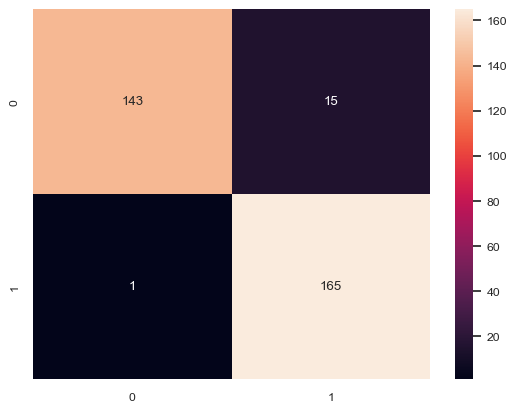

In [27]:
from sklearn.tree import DecisionTreeClassifier

print('Decision Tree Classifier')
# Create instance of model
Dtree = DecisionTreeClassifier()

# Pass training data into model
Dtree.fit(x_train, y_train)

from sklearn.metrics import accuracy_score
# prediction from the model
y_pred_Dtree = Dtree.predict(x_test)

# Accuracy
Dtree_accuracy = accuracy_score(y_test, y_pred_Dtree)
print('Accuracy', Dtree_accuracy)

from sklearn.metrics import precision_score, recall_score, confusion_matrix
# Calculate precision and recall
precision = precision_score(y_test, y_pred_Dtree)
recall = recall_score(y_test, y_pred_Dtree)
Dtree_accuracy = round(accuracy_score(y_test, y_pred_Dtree) * 100,2)

# Print the results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

print("--"*30)
# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred_Dtree)

sns.heatmap(confusion, annot=True, fmt="d")
print(classification_report(y_test,Dtree.predict(x_test)))

In [28]:
print("Decision Tree Classifier")
output = pd.DataFrame({'Real_class': y_test, 'Predicted_class': Dtree.predict(x_test)})
output.head()

Decision Tree Classifier


,Real_class,Predicted_class
1113,1,1
1061,0,0
1737,0,0
1550,0,0
420,0,0


Random Forest Classifier
------------------------------------------------------------
Accuracy 95.37 %
Precision: 0.92
Recall: 1.00
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       158
           1       0.92      1.00      0.96       166

    accuracy                           0.95       324
   macro avg       0.96      0.95      0.95       324
weighted avg       0.96      0.95      0.95       324



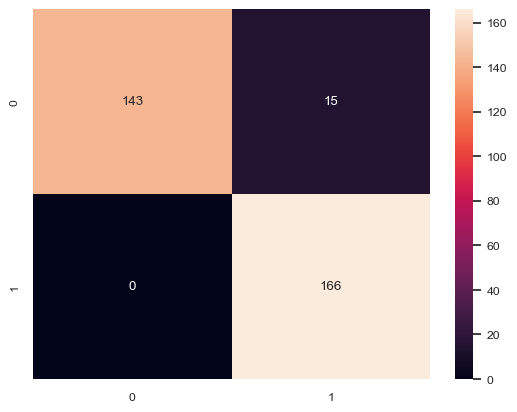

In [29]:
from sklearn.ensemble import RandomForestClassifier

print('Random Forest Classifier')
# Create instance of model
rfc = RandomForestClassifier()

# Pass training data into model
rfc.fit(x_train, y_train)
from sklearn.metrics import accuracy_score
# prediction from the model
y_pred_rfc = rfc.predict(x_test)
# Score It

# Accuracy
print('--'*30)
rfc_accuracy = round(accuracy_score(y_test, y_pred_rfc) * 100,2)
print('Accuracy', rfc_accuracy,'%')
from sklearn.metrics import precision_score, recall_score, confusion_matrix
# Calculate precision and recall
precision = precision_score(y_test, y_pred_rfc)
recall = recall_score(y_test, y_pred_rfc)

# Print the results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print("--"*30)
# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred_rfc)
sns.heatmap(confusion, annot=True, fmt="d")
print(classification_report(y_test,rfc.predict(x_test)))

In [30]:
print("Random Forest Classifier")
output = pd.DataFrame({'Real_class': y_test, 'Predicted_class': rfc.predict(x_test)})
output.head()

Random Forest Classifier


,Real_class,Predicted_class
1113,1,1
1061,0,0
1737,0,0
1550,0,0
420,0,0


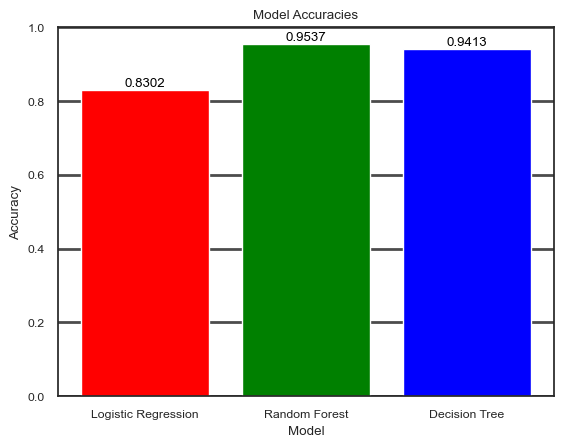

In [31]:
from matplotlib import pyplot as plt


log_reg_accuracy = 0.8302  # Accuracy value for Logistic Regression
rfc_accuracy = 0.9537      # Accuracy value for Random Forest Classifier
Dtree_accuracy = 0.9413    # Accuracy value for Decision Tree Classifier

frequencies = [log_reg_accuracy, rfc_accuracy, Dtree_accuracy]
colors = ['red', 'green', 'blue']  # List of colors for each bar

plt.bar(['Logistic Regression', 'Random Forest', 'Decision Tree'], frequencies, color=colors)

for i, v in enumerate(frequencies):
    plt.text(i, v + 0.01, str(v), color='black', ha='center')

plt.grid(color='black', linestyle='-', linewidth=2, axis='y', alpha=0.7)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()
